# Week 10: Time Series - ARIMA, VAR, GARCH

---

## 🎯 What You'll Learn This Week

Financial data is inherently temporal. Time series methods model serial dependencies, forecast future values, and capture volatility dynamics.

**Key Concepts:**
- Stationarity and why it matters
- ARIMA models for forecasting
- GARCH for volatility modeling
- VAR for multi-asset analysis

**Why This Matters:**
Understanding time series is fundamental to quantitative finance. Volatility forecasting drives options pricing, risk management, and position sizing.

---

## Table of Contents
1. Stationarity Testing
2. Autocorrelation Analysis
3. ARIMA Models
4. GARCH Volatility Models
5. Volatility Forecasting

---

In [1]:
# Standard imports and data loading
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Standard 5 equities for analysis
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'SPY']

# Fetch 5 years of data
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading market data...")
data = yf.download(TICKERS, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} days of data for {len(TICKERS)} tickers")
print(f"📅 Date range: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
print(returns.tail())

📥 Downloading market data...
✅ Loaded 1255 days of data for 5 tickers
📅 Date range: 2021-01-25 to 2026-01-22
Ticker          AAPL     GOOGL       JPM      MSFT       SPY
Date                                                        
2026-01-15 -0.006732 -0.009111  0.004515 -0.005921  0.002723
2026-01-16 -0.010379 -0.008354  0.010380  0.007007 -0.000838
2026-01-20 -0.034556 -0.024242 -0.031139 -0.011612 -0.020357
2026-01-21  0.003851  0.019814 -0.002312 -0.022903  0.011541
2026-01-22  0.010458  0.010932  0.009336  0.015289  0.007762


---

## 1. Stationarity Testing

### 🤔 Why Stationarity Matters

A time series is **stationary** if its statistical properties don't change over time:
- Constant mean
- Constant variance
- Autocovariance depends only on lag

**Key Insight:**
- **Prices**: Non-stationary (trend over time)
- **Returns**: Usually stationary (fluctuate around zero mean)

### ADF Test (Augmented Dickey-Fuller)
- Null hypothesis: Series has unit root (non-stationary)
- p-value < 0.05 → Reject null → **Stationary**

Stationarity Tests (ADF)
Series                             ADF Stat      p-value   Stationary
----------------------------------------------------------------------
AAPL Price                          -1.0831       0.7218           No
AAPL Return                        -34.9039       0.0000          Yes
MSFT Price                          -1.1851       0.6800           No
MSFT Return                        -22.6871       0.0000          Yes
GOOGL Price                          1.9883       0.9987           No
GOOGL Return                       -21.8384       0.0000          Yes
JPM Price                            0.2928       0.9770           No
JPM Return                         -34.4865       0.0000          Yes
SPY Price                            0.2956       0.9771           No
SPY Return                         -22.0954       0.0000          Yes


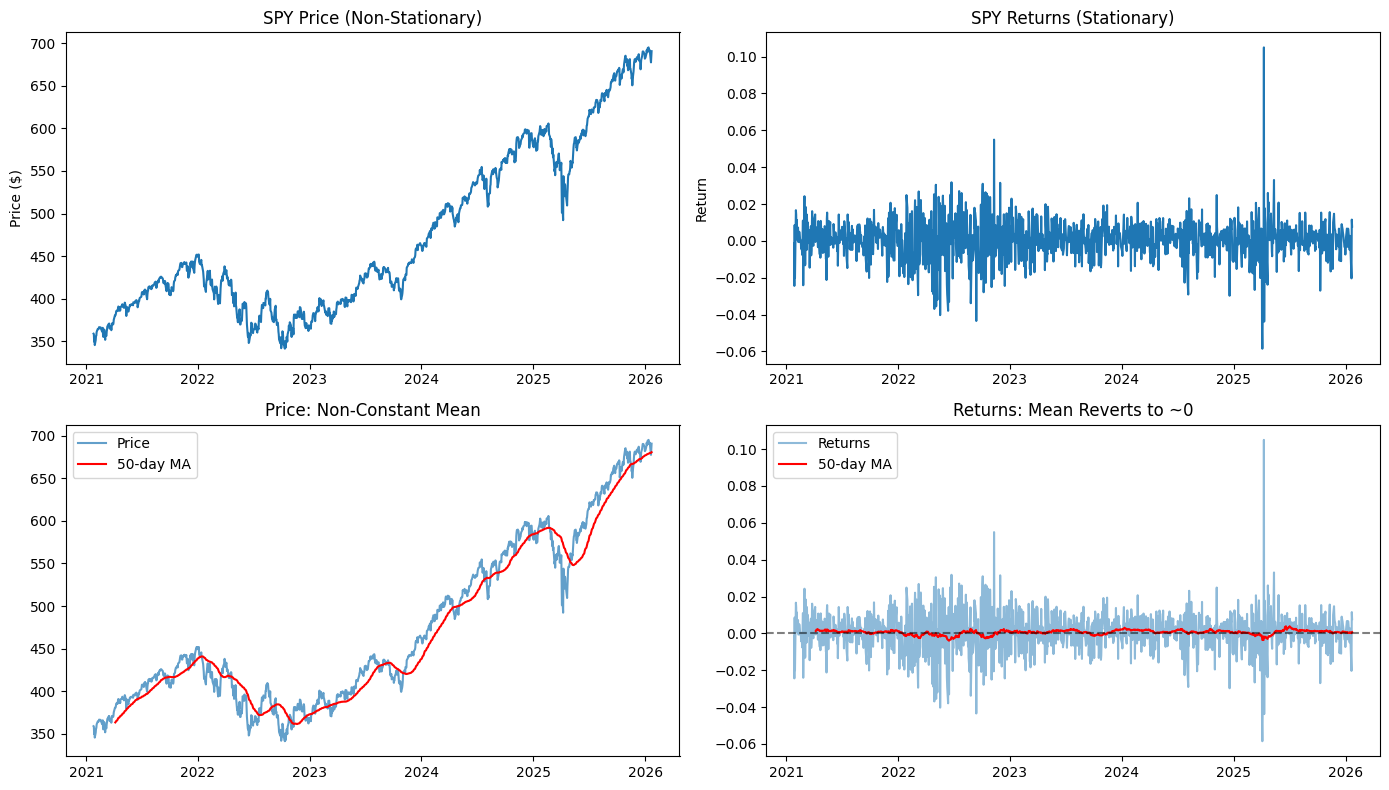


✅ Key Insight: Prices are non-stationary, returns are stationary!


In [2]:
# Stationarity testing
def adf_test(series, name):
    """Perform ADF test and return results."""
    result = adfuller(series.dropna())
    is_stationary = result[1] < 0.05
    return {
        'name': name,
        'adf_stat': result[0],
        'p_value': result[1],
        'stationary': 'Yes' if is_stationary else 'No'
    }

print("Stationarity Tests (ADF)")
print("="*70)
print(f"{'Series':<30} {'ADF Stat':>12} {'p-value':>12} {'Stationary':>12}")
print("-"*70)

results = []
for ticker in TICKERS:
    # Test prices
    price_result = adf_test(prices[ticker], f"{ticker} Price")
    results.append(price_result)
    
    # Test returns
    return_result = adf_test(returns[ticker], f"{ticker} Return")
    results.append(return_result)

for r in results:
    print(f"{r['name']:<30} {r['adf_stat']:>12.4f} {r['p_value']:>12.4f} {r['stationary']:>12}")

# Visualize price vs returns
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# SPY Price
axes[0, 0].plot(prices['SPY'])
axes[0, 0].set_title('SPY Price (Non-Stationary)')
axes[0, 0].set_ylabel('Price ($)')

# SPY Returns
axes[0, 1].plot(returns['SPY'])
axes[0, 1].set_title('SPY Returns (Stationary)')
axes[0, 1].set_ylabel('Return')

# Rolling mean (price)
rolling_mean = prices['SPY'].rolling(50).mean()
axes[1, 0].plot(prices['SPY'], alpha=0.7, label='Price')
axes[1, 0].plot(rolling_mean, 'r-', label='50-day MA')
axes[1, 0].set_title('Price: Non-Constant Mean')
axes[1, 0].legend()

# Rolling mean (returns)
rolling_mean_ret = returns['SPY'].rolling(50).mean()
axes[1, 1].plot(returns['SPY'], alpha=0.5, label='Returns')
axes[1, 1].plot(rolling_mean_ret, 'r-', label='50-day MA')
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Returns: Mean Reverts to ~0')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n✅ Key Insight: Prices are non-stationary, returns are stationary!")

---

## 2. Autocorrelation Analysis

### 🤔 What is Autocorrelation?

Autocorrelation measures how a series correlates with its past values.

**ACF (Autocorrelation Function):**
$$\rho_k = \frac{Cov(Y_t, Y_{t-k})}{Var(Y_t)}$$

**PACF (Partial ACF):**
- Correlation after removing intermediate effects
- Helps identify AR order

### Interpretation:
| Pattern | ACF | PACF | Model |
|---------|-----|------|-------|
| AR(p) | Decays | Cuts at p | Use PACF |
| MA(q) | Cuts at q | Decays | Use ACF |

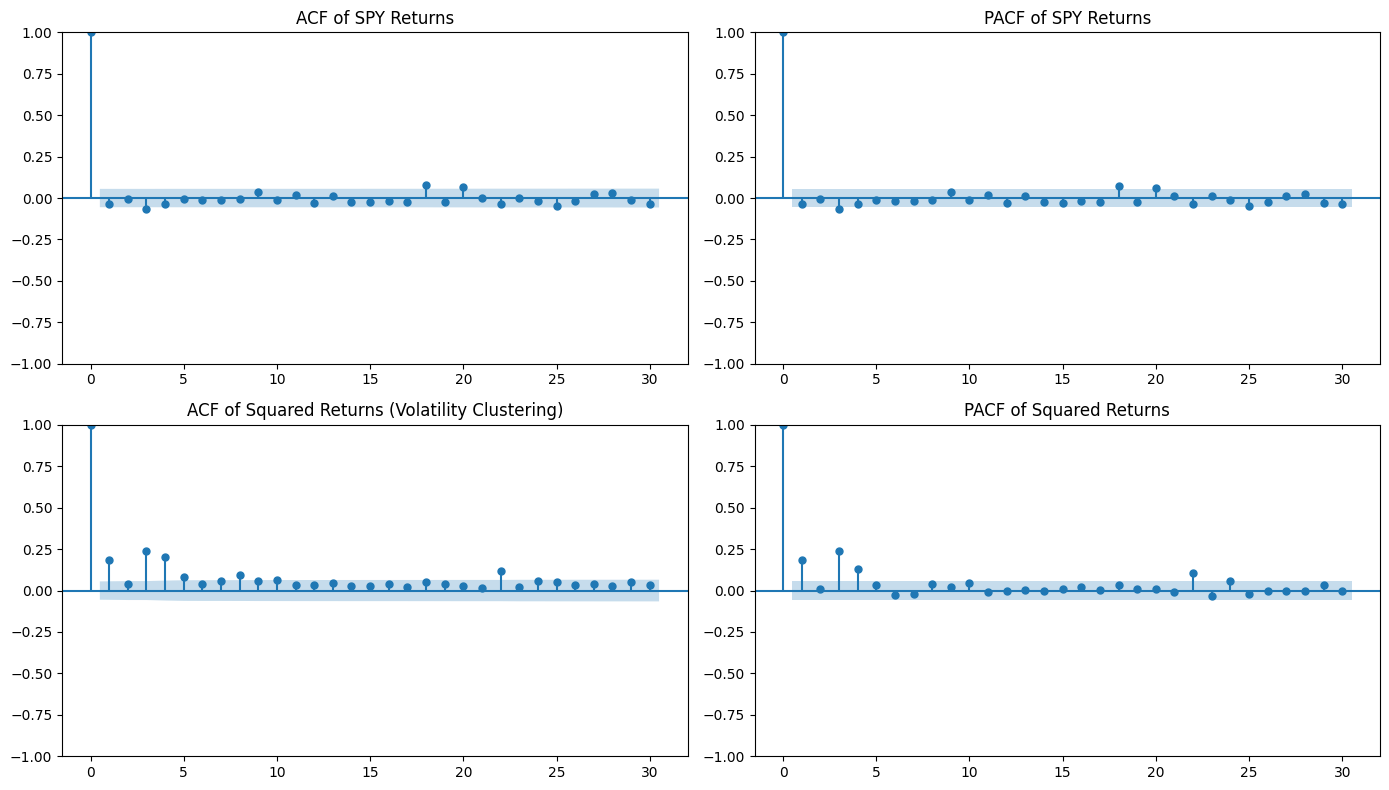

📊 Key Observations:
1. Returns show little autocorrelation (near efficient market)
2. Squared returns show significant autocorrelation (volatility clusters!)
3. This is why GARCH models are important for volatility modeling


In [3]:
# ACF and PACF analysis
spy_returns = returns['SPY']

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ACF of returns
plot_acf(spy_returns, lags=30, ax=axes[0, 0])
axes[0, 0].set_title('ACF of SPY Returns')

# PACF of returns
plot_pacf(spy_returns, lags=30, ax=axes[0, 1])
axes[0, 1].set_title('PACF of SPY Returns')

# ACF of squared returns (volatility clustering!)
plot_acf(spy_returns**2, lags=30, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Squared Returns (Volatility Clustering)')

# PACF of squared returns
plot_pacf(spy_returns**2, lags=30, ax=axes[1, 1])
axes[1, 1].set_title('PACF of Squared Returns')

plt.tight_layout()
plt.show()

print("📊 Key Observations:")
print("1. Returns show little autocorrelation (near efficient market)")
print("2. Squared returns show significant autocorrelation (volatility clusters!)")
print("3. This is why GARCH models are important for volatility modeling")

---

## 3. ARIMA Models

### 🤔 What is ARIMA?

**ARIMA(p, d, q):**
- **AR(p)**: Autoregressive - past values
- **I(d)**: Integrated - differencing for stationarity
- **MA(q)**: Moving Average - past errors

**Formula:**
$$Y_t = c + \sum_{i=1}^{p}\phi_i Y_{t-i} + \sum_{j=1}^{q}\theta_j \epsilon_{t-j} + \epsilon_t$$

### Finance Application:
- **Returns forecasting** (usually weak predictability)
- **Spread forecasting** for mean reversion strategies

In [4]:
# Fit ARIMA models to returns
print("ARIMA Model Fitting")
print("="*60)

# For returns, d=0 since already stationary
# Try different (p, q) combinations
from statsmodels.tsa.arima.model import ARIMA

orders = [(1, 0, 0), (1, 0, 1), (2, 0, 1), (1, 0, 2)]
arima_results = []

for order in orders:
    try:
        model = ARIMA(spy_returns, order=order)
        fit = model.fit()
        arima_results.append({
            'order': order,
            'aic': fit.aic,
            'bic': fit.bic,
            'model': fit
        })
        print(f"ARIMA{order}: AIC={fit.aic:.2f}, BIC={fit.bic:.2f}")
    except Exception as e:
        print(f"ARIMA{order}: Failed - {e}")

# Best model by AIC
best_model = min(arima_results, key=lambda x: x['aic'])
print(f"\n✅ Best model by AIC: ARIMA{best_model['order']}")

# Show model summary
print("\nBest Model Parameters:")
print(best_model['model'].summary().tables[1])

ARIMA Model Fitting
ARIMA(1, 0, 0): AIC=-7798.62, BIC=-7783.21
ARIMA(1, 0, 1): AIC=-7799.68, BIC=-7779.15
ARIMA(2, 0, 1): AIC=-7793.25, BIC=-7767.58
ARIMA(1, 0, 2): AIC=-7796.34, BIC=-7770.67

✅ Best model by AIC: ARIMA(1, 0, 1)

Best Model Parameters:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.814      0.070   -4.63e-05       0.001
ar.L1          0.6469      0.224      2.884      0.004       0.207       1.087
ma.L1         -0.6798      0.219     -3.110      0.002      -1.108      -0.251
sigma2         0.0001   2.46e-06     47.014      0.000       0.000       0.000


5-Day Return Forecast:
Day 1: 0.0436% (95% CI: [-2.0649%, 2.1521%])
Day 2: 0.0486% (95% CI: [-2.0611%, 2.1582%])
Day 3: 0.0518% (95% CI: [-2.0583%, 2.1619%])
Day 4: 0.0539% (95% CI: [-2.0565%, 2.1642%])
Day 5: 0.0552% (95% CI: [-2.0552%, 2.1656%])


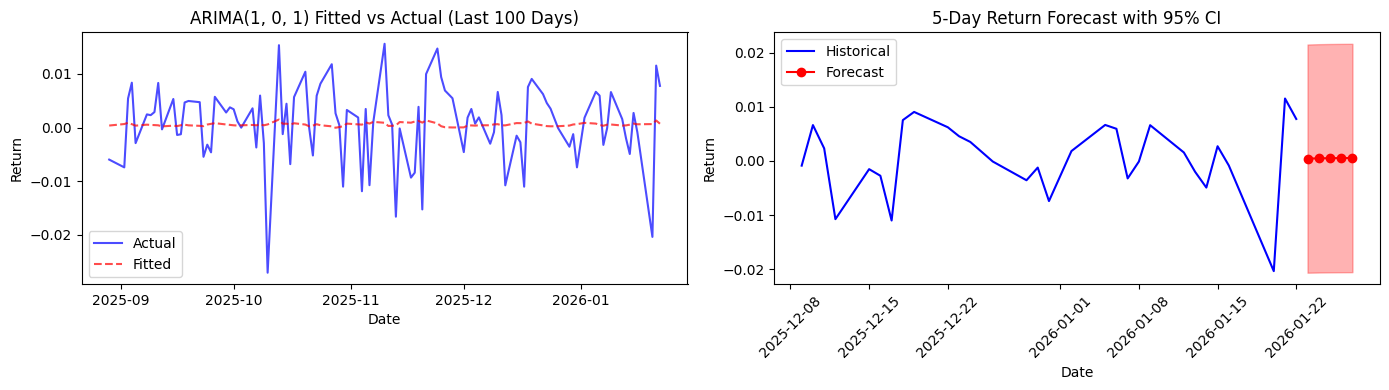


⚠️ Note: Return forecasting is notoriously difficult - markets are nearly efficient!


In [5]:
# ARIMA Forecasting
best_fit = best_model['model']

# In-sample fitted values
fitted = best_fit.fittedvalues

# Forecast next 5 days
forecast = best_fit.forecast(steps=5)
conf_int = best_fit.get_forecast(steps=5).conf_int()

print("5-Day Return Forecast:")
print("="*50)
for i, (f, ci_low, ci_high) in enumerate(zip(forecast, conf_int.iloc[:, 0], conf_int.iloc[:, 1])):
    print(f"Day {i+1}: {f:.4%} (95% CI: [{ci_low:.4%}, {ci_high:.4%}])")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Fitted vs Actual (last 100 days)
last_100 = spy_returns.iloc[-100:]
fitted_100 = fitted.iloc[-100:]

axes[0].plot(last_100.index, last_100.values, 'b-', alpha=0.7, label='Actual')
axes[0].plot(fitted_100.index, fitted_100.values, 'r--', alpha=0.7, label='Fitted')
axes[0].set_title(f'ARIMA{best_model["order"]} Fitted vs Actual (Last 100 Days)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Return')
axes[0].legend()
plt.xticks(rotation=45)

# Forecast
forecast_dates = pd.date_range(start=spy_returns.index[-1] + pd.Timedelta(days=1), periods=5)
axes[1].plot(spy_returns.index[-30:], spy_returns.values[-30:], 'b-', label='Historical')
axes[1].plot(forecast_dates, forecast.values, 'r-o', label='Forecast')
axes[1].fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], alpha=0.3, color='red')
axes[1].set_title('5-Day Return Forecast with 95% CI')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Return')
axes[1].legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\n⚠️ Note: Return forecasting is notoriously difficult - markets are nearly efficient!")

---

## 4. GARCH Volatility Models

### 🤔 Why GARCH?

**Key Observation:** Returns are uncorrelated, but squared returns ARE correlated!
- This means **volatility clusters** - high vol follows high vol

**GARCH(1,1):**
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

Where:
- $\omega$: Long-run variance weight
- $\alpha$: ARCH effect (reaction to recent shock)
- $\beta$: GARCH effect (persistence)
- $\alpha + \beta$: Persistence (close to 1 = slow mean reversion)

### Finance Application:
- **VaR calculation**
- **Options pricing** (volatility forecasts)
- **Position sizing** (reduce exposure in high vol)

GARCH(1,1) Model Results

Parameters:
  ω (omega):  0.038770
  α (alpha):  0.1149
  β (beta):   0.8494

  Persistence (α+β): 0.9642

  Long-run annualized volatility: 16.53%


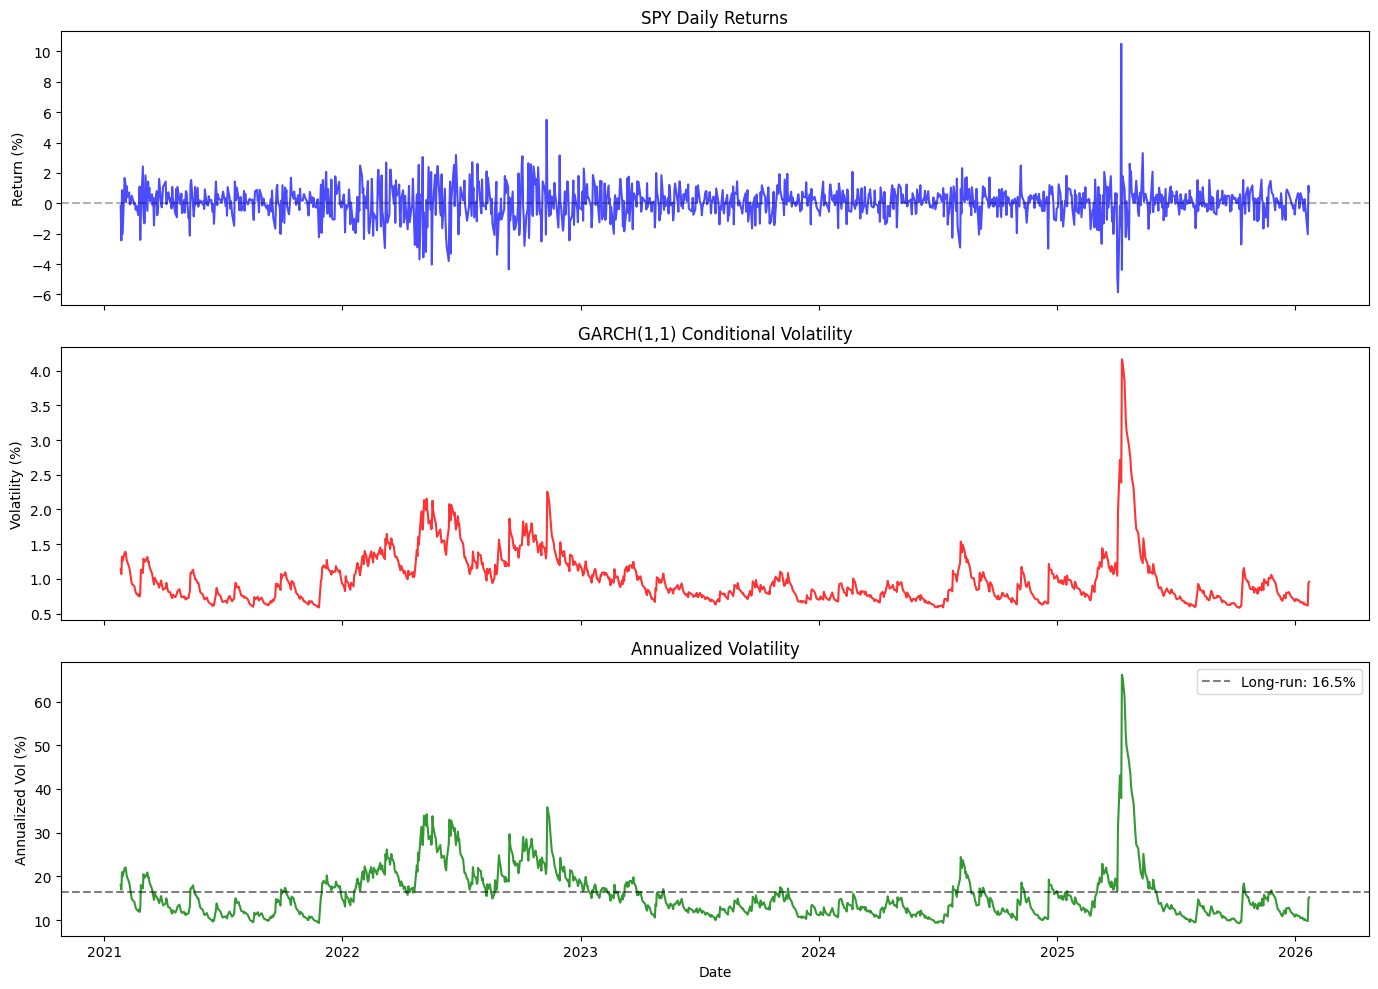

In [6]:
# Fit GARCH(1,1) to SPY returns
# Scale returns to percentages for numerical stability
spy_returns_pct = spy_returns * 100

# Fit GARCH(1,1)
garch_model = arch_model(spy_returns_pct, vol='Garch', p=1, q=1, mean='Constant')
garch_fit = garch_model.fit(disp='off')

print("GARCH(1,1) Model Results")
print("="*60)
print(f"\nParameters:")
print(f"  ω (omega):  {garch_fit.params['omega']:.6f}")
print(f"  α (alpha):  {garch_fit.params['alpha[1]']:.4f}")
print(f"  β (beta):   {garch_fit.params['beta[1]']:.4f}")
print(f"\n  Persistence (α+β): {garch_fit.params['alpha[1]'] + garch_fit.params['beta[1]']:.4f}")

# Long-run variance
alpha = garch_fit.params['alpha[1]']
beta = garch_fit.params['beta[1]']
omega = garch_fit.params['omega']
long_run_var = omega / (1 - alpha - beta)
long_run_vol = np.sqrt(long_run_var) * np.sqrt(252)  # Annualize

print(f"\n  Long-run annualized volatility: {long_run_vol:.2f}%")

# Conditional volatility
cond_vol = garch_fit.conditional_volatility

# Visualize
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Returns
axes[0].plot(spy_returns.index, spy_returns_pct.values, 'b-', alpha=0.7)
axes[0].set_ylabel('Return (%)')
axes[0].set_title('SPY Daily Returns')
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Conditional volatility
axes[1].plot(spy_returns.index, cond_vol.values, 'r-', alpha=0.8)
axes[1].set_ylabel('Volatility (%)')
axes[1].set_title('GARCH(1,1) Conditional Volatility')

# Annualized volatility
annual_vol = cond_vol * np.sqrt(252)
axes[2].plot(spy_returns.index, annual_vol.values, 'g-', alpha=0.8)
axes[2].axhline(y=long_run_vol, color='k', linestyle='--', alpha=0.5, label=f'Long-run: {long_run_vol:.1f}%')
axes[2].set_ylabel('Annualized Vol (%)')
axes[2].set_title('Annualized Volatility')
axes[2].set_xlabel('Date')
axes[2].legend()

plt.tight_layout()
plt.show()

GARCH Volatility Forecasting

Volatility Forecast (Daily %):
  Day 1: 0.93% daily (14.8% annualized)
  Day 2: 0.94% daily (14.9% annualized)
  Day 3: 0.94% daily (14.9% annualized)
  Day 4: 0.95% daily (15.0% annualized)
  Day 5: 0.95% daily (15.1% annualized)
  Day 6: 0.95% daily (15.1% annualized)
  Day 7: 0.96% daily (15.2% annualized)
  Day 8: 0.96% daily (15.2% annualized)
  Day 9: 0.96% daily (15.3% annualized)
  Day 10: 0.96% daily (15.3% annualized)

📊 Current volatility: 0.96%
📊 Historical average: 1.00%
📊 Historical max: 4.16%


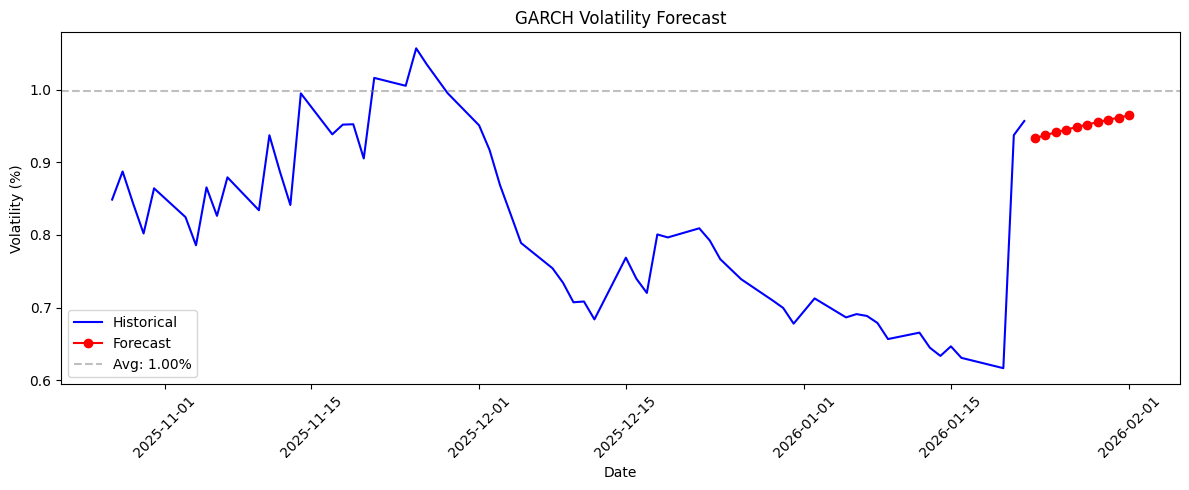

In [7]:
# GARCH Volatility Forecasting
print("GARCH Volatility Forecasting")
print("="*60)

# Forecast volatility for next 10 days
forecast_horizon = 10
garch_forecast = garch_fit.forecast(horizon=forecast_horizon)

# Get variance forecasts
var_forecast = garch_forecast.variance.values[-1, :]
vol_forecast = np.sqrt(var_forecast)

print(f"\nVolatility Forecast (Daily %):")
for i in range(forecast_horizon):
    annual_vol = vol_forecast[i] * np.sqrt(252)
    print(f"  Day {i+1}: {vol_forecast[i]:.2f}% daily ({annual_vol:.1f}% annualized)")

# Compare to historical
current_vol = cond_vol.iloc[-1]
hist_avg_vol = cond_vol.mean()
hist_max_vol = cond_vol.max()

print(f"\n📊 Current volatility: {current_vol:.2f}%")
print(f"📊 Historical average: {hist_avg_vol:.2f}%")
print(f"📊 Historical max: {hist_max_vol:.2f}%")

# Visualize forecast
fig, ax = plt.subplots(figsize=(12, 5))

# Historical volatility (last 60 days)
hist_dates = spy_returns.index[-60:]
hist_vol = cond_vol.iloc[-60:]

# Forecast dates
forecast_dates = pd.date_range(start=spy_returns.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)

ax.plot(hist_dates, hist_vol.values, 'b-', label='Historical')
ax.plot(forecast_dates, vol_forecast, 'r-o', label='Forecast')
ax.axhline(y=hist_avg_vol, color='gray', linestyle='--', alpha=0.5, label=f'Avg: {hist_avg_vol:.2f}%')
ax.set_xlabel('Date')
ax.set_ylabel('Volatility (%)')
ax.set_title('GARCH Volatility Forecast')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

GARCH Analysis for All Tickers
Ticker         α (ARCH)    β (GARCH)  Persistence     Ann. Vol
----------------------------------------------------------------------
AAPL             0.0672       0.9004       0.9676       27.16%
MSFT             0.0368       0.9515       0.9883       25.60%
GOOGL            0.0216       0.9580       0.9796       30.67%
JPM              0.1135       0.6480       0.7615       24.26%
SPY              0.1149       0.8494       0.9642       16.53%


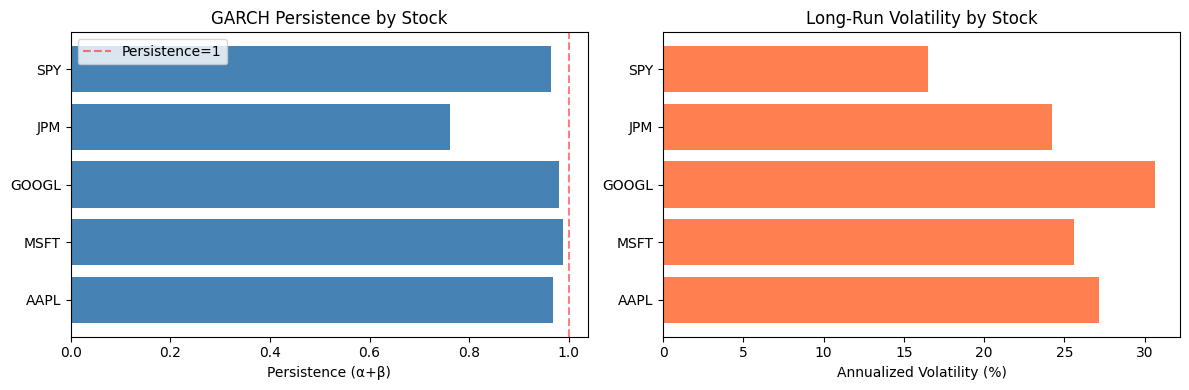

In [8]:
# Apply GARCH to all tickers
print("GARCH Analysis for All Tickers")
print("="*70)
print(f"{'Ticker':<10} {'α (ARCH)':>12} {'β (GARCH)':>12} {'Persistence':>12} {'Ann. Vol':>12}")
print("-"*70)

garch_results = {}
for ticker in TICKERS:
    ret_pct = returns[ticker] * 100
    
    try:
        model = arch_model(ret_pct, vol='Garch', p=1, q=1, mean='Constant')
        fit = model.fit(disp='off')
        
        alpha = fit.params['alpha[1]']
        beta = fit.params['beta[1]']
        omega = fit.params['omega']
        persistence = alpha + beta
        long_run_vol = np.sqrt(omega / (1 - alpha - beta)) * np.sqrt(252)
        
        garch_results[ticker] = {
            'alpha': alpha,
            'beta': beta,
            'persistence': persistence,
            'long_run_vol': long_run_vol,
            'fit': fit
        }
        
        print(f"{ticker:<10} {alpha:>12.4f} {beta:>12.4f} {persistence:>12.4f} {long_run_vol:>11.2f}%")
    except Exception as e:
        print(f"{ticker:<10} {'Failed':>12}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Persistence comparison
tickers_plot = [t for t in TICKERS if t in garch_results]
persistence_vals = [garch_results[t]['persistence'] for t in tickers_plot]
axes[0].barh(tickers_plot, persistence_vals, color='steelblue')
axes[0].axvline(x=1, color='r', linestyle='--', alpha=0.5, label='Persistence=1')
axes[0].set_xlabel('Persistence (α+β)')
axes[0].set_title('GARCH Persistence by Stock')
axes[0].legend()

# Long-run volatility comparison
vol_vals = [garch_results[t]['long_run_vol'] for t in tickers_plot]
axes[1].barh(tickers_plot, vol_vals, color='coral')
axes[1].set_xlabel('Annualized Volatility (%)')
axes[1].set_title('Long-Run Volatility by Stock')

plt.tight_layout()
plt.show()

---

## 📊 Summary & Key Takeaways

### What We Learned:

1. **Stationarity**: Prices are non-stationary, returns are stationary
2. **Autocorrelation**: Returns have low ACF, but squared returns are autocorrelated
3. **ARIMA**: Forecasts returns (weak predictability in practice)
4. **GARCH**: Models volatility clustering, crucial for risk management

### Key GARCH Insights:

| Parameter | Typical Value | Meaning |
|-----------|---------------|---------|
| α (alpha) | 0.05-0.15 | Reaction to shocks |
| β (beta) | 0.80-0.95 | Volatility persistence |
| α + β | 0.90-0.99 | Close to 1 = slow mean reversion |

### Trading Applications:

| Concept | Application |
|---------|-------------|
| Stationarity | Use returns, not prices for modeling |
| GARCH | VaR, position sizing, options pricing |
| Volatility forecast | Dynamic hedging, risk budgeting |

---

## 🔑 Interview Questions

1. **Why use log returns instead of prices?**
2. **What does volatility clustering mean?**
3. **How do you interpret GARCH persistence?**
4. **How would you use GARCH for risk management?**

---